<a href="https://colab.research.google.com/github/kasev/PIA/blob/master/scripts/2_EXPLORATIONS%2BREPLACEMENTS_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
from oauth2client.client import GoogleCredentials

!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
!pip install anda
from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

     |████████████████████████████████| 21.3MB 1.3MB/s 


In [2]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
### authorize google sheets
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [5]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [6]:
# look at first 5 rows
c_aristotelicum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents
678,tlg0086.tlg001.1st1K-grc2.xml,Aristotle,Aristotelis Analytica Priora et Posteriora; Ar...,ΑΝΑΛΥΤΙΚΩΝ ΠΡΟΤΕΡΩΝ Α. Πρῶτον εἰπεῖν περὶ τί κ...,tlg0086,tlg0086.tlg001,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,59772,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",21150,3645
679,tlg0086.tlg002.1st1K-grc2.xml,Aristotle,De anima; Aritoteles De anima,ΠEP1 ΨΥΧΗΣ Α Τῶν καλῶν καὶ τιμίων τὴν εἴδησιν ...,tlg0086,tlg0086.tlg002,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,20988,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",8893,1306
681,tlg0086.tlg005.1st1K-grc1.xml,Aristotle,De caelo; Aristoteles De coelo et De generatio...,ΠEPI ΟΥΡΑΝΟΥ A. Ἡ περὶ φύσεως ἐπιστήμη σχεδὸν ...,tlg0086,tlg0086.tlg005,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,31395,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",12915,1986
682,tlg0086.tlg006.1st1K-grc1.xml,Aristotle,Categoriae; Aristotelis Opera,ΚΑΤΗΓΟΡΙΑΙ. ὉΜΩΝΥΜΑ λέγεται ὧν ὄνομα μόνον κοι...,tlg0086,tlg0086.tlg006,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,10317,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",4372,659
683,tlg0086.tlg008.1st1K-grc1.xml,Aristotle,De divinatione per somnum; Aristotelis Opera,ΠΕΡΙ ΕΝΥΠΝΙΩΝ ΚΑΙ ΤΗΣ ΚΑΘ’ ΥΠΝΟΝ ΜΑΝΤΙΚΗΣ. Περ...,tlg0086,tlg0086.tlg008,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,1207,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",533,69


# Exploring Nicomachean Ethics
feel free to skip this section

In [12]:
EN_df = c_aristotelicum[c_aristotelicum["doc_id"]=="tlg0086.tlg010"]
EN_df

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents
685,tlg0086.tlg010.perseus-grc1.xml,Aristotle,Nicomachean Ethics; Machine readable text; ed....,"βοοκ 1 πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ ...",tlg0086,tlg0086.tlg010,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,56638,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",23811,3897


In [13]:
EN_df["string"].tolist()[0][:100]

'βοοκ 1 πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ πρᾶξίς τε καὶ προαίρεσις, ἀγαθοῦ τινὸς ἐφίεσθαι δοκεῖ· διὸ καλῶς ἀπεφήναντο τἀγαθόν, οὗ πάντʼ ἐφίεται. διαφορὰ δέ τις φαίνεται τῶν τελῶν· τὰ μὲν γάρ εἰσιν ἐνέργειαι, τὰ δὲ παρʼ αὐτὰς ἔργα τινά. ὧν δʼ εἰσὶ τέλη τινὰ παρὰ τὰς πράξεις, ἐν τούτοις βελτίω πέφυκε τῶν ἐνεργειῶν τὰ ἔργα. πολλῶν δὲ πράξεων οὐσῶν καὶ τεχνῶν καὶ ἐπιστημῶν πολλὰ γίνεται καὶ τὰ τέλη· ἰατρικῆς μὲν γὰρ ὑγίεια, ναυπηγικῆς δὲ πλοῖον, στρατηγικῆς δὲ νίκη, οἰκονομικῆς δὲ πλοῦτος. ὅσαι δʼ εἰσὶ τῶν τοιούτων ὑπὸ μίαν τινὰ δύναμιν, καθάπερ ὑπὸ τὴν ἱππικὴν χαλινοποιικὴ καὶ ὅσαι ἄλλαι τῶν ἱππικῶν ὀργάνων εἰσίν, αὕτη δὲ καὶ πᾶσα πολεμικὴ πρᾶξις ὑπὸ τὴν στρατηγικήν, κατὰ τὸν αὐτὸν δὴ τρόπον ἄλλαι ὑφʼ ἑτέρας· ἐν ἁπάσαις δὲ τὰ τῶν ἀρχιτεκτονικῶν τέλη πάντων ἐστὶν αἱρετώτερα τῶν ὑπʼ αὐτά· τούτων γὰρ χάριν κἀκεῖνα διώκεται. διαφέρει δʼ οὐδὲν τὰς ἐνεργείας αὐτὰς εἶναι τὰ τέλη τῶν πράξεων ἢ παρὰ ταύτας ἄλλο τι, καθάπερ ἐπὶ τῶν λεχθεισῶν ἐπιστημῶν. εἰ δή τι τέλος ἐστὶ τῶν πρακτῶν ὃ διʼ αὑτ

In [15]:
print(EN_df["lemmatized_sentences"].tolist()[0][:10])

[['βοοκ', 'πᾶς', 'τέχνη', 'πᾶς', 'μέθοδος', 'ὅμοιος', 'πρᾶξίς', 'προαίρεσις', 'ἀγαθός', 'ἐφίημι', 'δοκέω'], ['καλός', 'ἀποφαίνω', 'ἀγαθός', 'ἵημι', 'πάντʼ', 'ἐφίημι'], ['διαφορά', 'φαίνω', 'τέλος'], ['εἶμι', 'ἐνέργεια', 'παρʼ', 'ἔργον'], ['εἶμι', 'τέλος', 'πρᾶξις', 'βελτίων', 'φύω', 'ἐνέργεια', 'ἔργον'], ['πολύς', 'πρᾶξις', 'τέχνη', 'ἐπιστήμη', 'πολύς', 'γίγνομαι', 'τέλος'], ['ἰατρικός', 'ὑγίεια', 'ναυπηγικός', 'πλοῖον', 'στρατηγικός', 'νίκη', 'οἰκονομικός', 'πλοῦτος'], ['ὅσος', 'εἶμι', 'μίαν', 'δύναμις', 'ἱππικην', 'χαλινοποιική', 'ὅσος', 'ἱππικός', 'ὄργανον', 'εἶμι', 'πᾶς', 'πολεμικός', 'πρᾶξις', 'στρατηγικός', 'τρόπος', 'ὑφʼ', 'ἕτερος'], ['ἅπας', 'ἀρχιτεκτονικῶν', 'τέλος', 'πᾶς', 'αἱρετός', 'ὑπʼ'], ['χάρις', 'ἐκεῖνος', 'διώκω']]


In [16]:
EN_df["lemmatized_sentences"].tolist()[0][:5]

[['βοοκ',
  'πᾶς',
  'τέχνη',
  'πᾶς',
  'μέθοδος',
  'ὅμοιος',
  'πρᾶξίς',
  'προαίρεσις',
  'ἀγαθός',
  'ἐφίημι',
  'δοκέω'],
 ['καλός', 'ἀποφαίνω', 'ἀγαθός', 'ἵημι', 'πάντʼ', 'ἐφίημι'],
 ['διαφορά', 'φαίνω', 'τέλος'],
 ['εἶμι', 'ἐνέργεια', 'παρʼ', 'ἔργον'],
 ['εἶμι', 'τέλος', 'πρᾶξις', 'βελτίων', 'φύω', 'ἐνέργεια', 'ἔργον']]

In [17]:
" ".join(EN_df["lemmatized_sentences"].tolist()[0][0])

'βοοκ πᾶς τέχνη πᾶς μέθοδος ὅμοιος πρᾶξίς προαίρεσις ἀγαθός ἐφίημι δοκέω'

In [18]:
EN_sentences = ""
for sentence in EN_df["lemmatized_sentences"].tolist()[0]:
  EN_sentences = EN_sentences + " ".join(sentence) + ". "

In [20]:
EN_sentences[:1000]

'βοοκ πᾶς τέχνη πᾶς μέθοδος ὅμοιος πρᾶξίς προαίρεσις ἀγαθός ἐφίημι δοκέω. καλός ἀποφαίνω ἀγαθός ἵημι πάντʼ ἐφίημι. διαφορά φαίνω τέλος. εἶμι ἐνέργεια παρʼ ἔργον. εἶμι τέλος πρᾶξις βελτίων φύω ἐνέργεια ἔργον. πολύς πρᾶξις τέχνη ἐπιστήμη πολύς γίγνομαι τέλος. ἰατρικός ὑγίεια ναυπηγικός πλοῖον στρατηγικός νίκη οἰκονομικός πλοῦτος. ὅσος εἶμι μίαν δύναμις ἱππικην χαλινοποιική ὅσος ἱππικός ὄργανον εἶμι πᾶς πολεμικός πρᾶξις στρατηγικός τρόπος ὑφʼ ἕτερος. ἅπας ἀρχιτεκτονικῶν τέλος πᾶς αἱρετός ὑπʼ. χάρις ἐκεῖνος διώκω. διαφέρω ἐνέργεια τέλος πρᾶξις ἐπιστήμη. τέλος πρακτός διʼ βούλομαι πᾶς διʼ ἕτερος αἱρέω ʽπρόεισι γʼ ἄπειρος ὥστʼ κενός μάταιος ὄρεξις δῆλος τοῦτʼ ἐάω ἀγαθός ἄριστον. ἆρʼ βιός γνῶσις μέγας ἔχις ῥοπή τοξότης σκοπός μαλλός τυγχάνω δέον. πειρατέος τύπος περιλαμβάνω ποτʼ ἐπιστήμη δύναμις. δοκέω κύριος ἀρχιτεκτονικῆς. πολιτικός φαίνω. χρεὼν ἐπιστήμη πόλις πόα ἕκαστος μανθάνω διατάσσω. ὁράω ἔντιμος δύναμις οἷος στρατηγικός οἰκονομικην ῥητορικός. λοιπός πρακτικός ἐπιστήμη δεῖ πράσσω ἀπέχ

In [ ]:
file_object = open("EN_sentences.txt","w") 
file_object.write(EN_sentences)

172302

In [ ]:
# uncomment the rows below to be ready for file download
# from google.colab import files
#files.download("EN_sentences.txt")

In [21]:
print(EN_df["lemmata"].tolist()[0][:100])

['βοοκ', 'πᾶς', 'τέχνη', 'πᾶς', 'μέθοδος', 'ὅμοιος', 'πρᾶξίς', 'προαίρεσις', 'ἀγαθός', 'ἐφίημι', 'δοκέω', 'καλός', 'ἀποφαίνω', 'ἀγαθός', 'ἵημι', 'πάντʼ', 'ἐφίημι', 'διαφορά', 'φαίνω', 'τέλος', 'εἶμι', 'ἐνέργεια', 'παρʼ', 'ἔργον', 'εἶμι', 'τέλος', 'πρᾶξις', 'βελτίων', 'φύω', 'ἐνέργεια', 'ἔργον', 'πολύς', 'πρᾶξις', 'τέχνη', 'ἐπιστήμη', 'πολύς', 'γίγνομαι', 'τέλος', 'ἰατρικός', 'ὑγίεια', 'ναυπηγικός', 'πλοῖον', 'στρατηγικός', 'νίκη', 'οἰκονομικός', 'πλοῦτος', 'ὅσος', 'εἶμι', 'μίαν', 'δύναμις', 'ἱππικην', 'χαλινοποιική', 'ὅσος', 'ἱππικός', 'ὄργανον', 'εἶμι', 'πᾶς', 'πολεμικός', 'πρᾶξις', 'στρατηγικός', 'τρόπος', 'ὑφʼ', 'ἕτερος', 'ἅπας', 'ἀρχιτεκτονικῶν', 'τέλος', 'πᾶς', 'αἱρετός', 'ὑπʼ', 'χάρις', 'ἐκεῖνος', 'διώκω', 'διαφέρω', 'ἐνέργεια', 'τέλος', 'πρᾶξις', 'ἐπιστήμη', 'τέλος', 'πρακτός', 'διʼ', 'βούλομαι', 'πᾶς', 'διʼ', 'ἕτερος', 'αἱρέω', 'ʽπρόεισι', 'γʼ', 'ἄπειρος', 'ὥστʼ', 'κενός', 'μάταιος', 'ὄρεξις', 'δῆλος', 'τοῦτʼ', 'ἐάω', 'ἀγαθός', 'ἄριστον', 'ἆρʼ', 'βιός', 'γνῶσις']


In [ ]:
# gr.return_all_unique_lemmata("πρᾶξίς")

# Key term replacement

In [7]:
# manually define key terms we are interested in:
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [8]:
### produce a list of all words from the authors
### (useful for a preliminary exploration)
aristotle_list = []
for list_element in c_aristotelicum["lemmata"].tolist():
  aristotle_list.extend(list_element)
hippocrates_list = []
for list_element in c_hippocraticum["lemmata"].tolist():
  hippocrates_list.extend(list_element)
one_merged_list = aristotle_list + hippocrates_list

In [22]:
# unique word forms
matches = []
for pattern_tuple in keyterm_patterns:
  r = re.compile(pattern_tuple[0])
  matches.extend([(pattern_tuple[0], pattern_tuple[1], match, aristotle_list.count(match), hippocrates_list.count(match), gr.lemma_translator(match)) for match in list(filter(r.match, list(set(aristotle_list + hippocrates_list))))])
matches_df = pd.DataFrame(matches, columns=["pattern", "replacement", "match", "c_aristotelicum", "c_hippocraticum", "translation"])
matches_df

,pattern,replacement,match,c_aristotelicum,c_hippocraticum,translation
0,^λ[υ|ύ]π.+,λύπ*,λυπεῖταί,2,0,
1,^λ[υ|ύ]π.+,λύπ*,λυπητικός,1,0,
2,^λ[υ|ύ]π.+,λύπ*,λυπεόντων,0,1,
3,^λ[υ|ύ]π.+,λύπ*,λυπηρότερά,0,1,
4,^λ[υ|ύ]π.+,λύπ*,λυπέον,0,8,
...,...,...,...,...,...,...
120,^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+,πόνο*,πονητέος,0,1,one must toil
121,^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+,πόνο*,πονεούσης,0,1,
122,^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+,πόνο*,πόνοισίν,0,1,
123,^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+,πόνο*,πονέῃ,0,11,


In [23]:
### look at all unique matched words
print(matches_df["match"].tolist())

['λυπεῖταί', 'λυπητικός', 'λυπεόντων', 'λυπηρότερά', 'λυπέον', 'λυπέῃ', 'λυπή', 'λύπαςμεσότης', 'λυπέεται', 'λυπέοντα', 'λυπηθῆ', 'λυπέουσα', 'λυπηρός', 'λυπηθήσοιτʼ', 'λυπέω', 'λυπέονταί', 'λυπέοιτο', 'λυπέοντος', 'λυπέουσιν', 'λύπαςοὐ', 'λυπέωσι', 'λυπρᾷ', 'λύπη', 'λυπέουσαν', 'λυποδίαν', 'λυπεῖταἰ', 'λυπούμενός', 'λύπημα', 'ἀλγέοιεν', 'ἀλγεόντων', 'ἀλγέω', 'ἄλγεσκ', 'ἀλγέοντος', 'ἀλγέοντα', 'ἀλγέον', 'ἀλγεινην', 'ἀλγεινός', 'ἀλγέοντες', 'ἀλγέουσι', 'ἄλγημά', 'ἀλγήσῃ', 'ἀλγέοντάς', 'ἀλγέωσι', 'ἀλγεῦντα', 'ἄλγος', 'ἀλγεούσης', 'ἄλγημα', 'ἀλγέῃ', 'ἀλγέουσιν', 'ἀλγέοντι', 'ἄλγησις', 'ἀλγήσαν', 'ἀλγηδὼν', 'ἀλγήμασι', 'ἄλγλος', 'ἀλγέοντας', 'ἀλγήσωσιν', 'ἀλγηδών', 'ἀλγεούσῃσι', 'ἀλγέειν', 'ἀλγέουσαν', 'ὀδύνη', 'ὀδυνης', 'ὀδυνάω', 'ὀδυνῶδες', 'ὀδυνώδης', 'ὀδυνώδεας', 'ὀδυνηθῇ', 'ὀδυνώδεα', 'ὀδυνωμένους', 'ὠδυναμίη', 'ὀδυνηρός', 'ὀδυνέωνται', 'ὀδυνέων', 'ὀδυνώμενα', 'ὀδύνῃσί', 'ὀδυναίτερον', 'ὀδυνήμασι', 'ὀδυνημάτων', 'ὀδυνωμένῳ', 'ὀδυνώδεες', 'ὀδυνήματα', 'ὀδύνατον', 'ὀδυνῶνται', 'ὀδυνῇ', 

In [24]:
# uncomment the following to export to gsheet: 
set_with_dataframe(PIA_overview.add_worksheet("matches_20200814", 1, 1), matches_df)

In [25]:
# make 
def replacer_word_list(pattern, product, word_list):
  return [re.sub(pattern, product, word) for word in word_list]

def replace_keywords(list_of_words, list_of_tuples):
  for pattern in list_of_tuples:
    list_of_words = replacer_word_list(pattern[0], pattern[1], list_of_words)
  return list_of_words

In [26]:
# test 1:
testlist = ["μέλυπρᾷ", "λυπρᾷ"] 
for word in testlist:
  print(re.sub(keyterm_patterns[0][0], keyterm_patterns[0][1], word))

μέλυπρᾷ
λύπ*


In [27]:
### test 2:
word_list_test = ['βοοκ', 'πᾶς', 'μέλυπρᾷ', "ἄλγτέχνη",'τέχνη' ,'πᾶς', 'μέθοδος', 'ὅμοιος', "λύπη",'πρᾶξίς', 'προαίρεσις', 'ἀγαθός', 'ἐφίημι']
replace_keywords(word_list_test, keyterm_patterns)

['βοοκ',
 'πᾶς',
 'μέλυπρᾷ',
 'ἄλγ*',
 'τέχνη',
 'πᾶς',
 'μέθοδος',
 'ὅμοιος',
 'λύπ*',
 'πρᾶξίς',
 'προαίρεσις',
 'ἀγαθός',
 'ἐφίημι']

In [28]:
# apply the replacement on the level of individual words
c_aristotelicum["lemmata_repl"] = c_aristotelicum.apply(lambda row: replace_keywords(row["lemmata"], keyterm_patterns), axis=1)
c_hippocraticum["lemmata_repl"] = c_hippocraticum.apply(lambda row: replace_keywords(row["lemmata"], keyterm_patterns), axis=1)

In [29]:
# apply the replacement on the sentences
def replace_in_sentences(list_of_sentences):
  return [replace_keywords(sentence, keyterm_patterns) for sentence in list_of_sentences]
c_aristotelicum["lemmatized_sentences_repl"] = c_aristotelicum.apply(lambda row: replace_in_sentences(row["lemmatized_sentences"]), axis=1)
c_hippocraticum["lemmatized_sentences_repl"] = c_hippocraticum.apply(lambda row: replace_in_sentences(row["lemmatized_sentences"]), axis=1)

In [30]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)

In [32]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [33]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [ ]:
# what columns we have
# (which columns to drop while exporting to gsheet - "string" etc. contain large data)
print(list(c_aristotelicum.columns))

['filename', 'author', 'title', 'string', 'author_id', 'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience', 'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount', 'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']


In [34]:
# uncomment to export overview data to gsheet
set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200814",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200814",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

# Overview graphs

In [38]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*",	"πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: row[term] / row["lemmata_wordcount"], axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: row[term] / row["lemmata_wordcount"], axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["lemmata_wordcount"], axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["lemmata_wordcount"], axis=1)

In [39]:
c_aristotelicum

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents,lemmata_repl,lemmatized_sentences_repl,λύπ*,ἄλγ*,ὀδύν*,πόνο*,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
678,tlg0086.tlg001.1st1K-grc2.xml,Aristotle,Aristotelis Analytica Priora et Posteriora; Ar...,ΑΝΑΛΥΤΙΚΩΝ ΠΡΟΤΕΡΩΝ Α. Πρῶτον εἰπεῖν περὶ τί κ...,tlg0086,tlg0086.tlg001,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,59772,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",21150,3645,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",0,1,0,0,0.000000,0.000047,0.000000,0.000000,0.000047
679,tlg0086.tlg002.1st1K-grc2.xml,Aristotle,De anima; Aritoteles De anima,ΠEP1 ΨΥΧΗΣ Α Τῶν καλῶν καὶ τιμίων τὴν εἴδησιν ...,tlg0086,tlg0086.tlg002,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,20988,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",8893,1306,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",12,0,0,0,0.001349,0.000000,0.000000,0.000000,0.001349
681,tlg0086.tlg005.1st1K-grc1.xml,Aristotle,De caelo; Aristoteles De coelo et De generatio...,ΠEPI ΟΥΡΑΝΟΥ A. Ἡ περὶ φύσεως ἐπιστήμη σχεδὸν ...,tlg0086,tlg0086.tlg005,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,31395,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",12915,1986,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",0,0,0,1,0.000000,0.000000,0.000000,0.000077,0.000077
682,tlg0086.tlg006.1st1K-grc1.xml,Aristotle,Categoriae; Aristotelis Opera,ΚΑΤΗΓΟΡΙΑΙ. ὉΜΩΝΥΜΑ λέγεται ὧν ὄνομα μόνον κοι...,tlg0086,tlg0086.tlg006,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,10317,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",4372,659,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",2,0,0,0,0.000457,0.000000,0.000000,0.000000,0.000457
683,tlg0086.tlg008.1st1K-grc1.xml,Aristotle,De divinatione per somnum; Aristotelis Opera,ΠΕΡΙ ΕΝΥΠΝΙΩΝ ΚΑΙ ΤΗΣ ΚΑΘ’ ΥΠΝΟΝ ΜΑΝΤΙΚΗΣ. Περ...,tlg0086,tlg0086.tlg008,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,1207,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",533,69,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
684,tlg0086.tlg009.perseus-grc1.xml,Aristotle,Eudemian Ethics (Greek). Machine readable text...,ὁ μὲν ἐν Δήλῳ παρὰ τῷ θεῷ τὴν αὑτοῦ γνώμην ἀπο...,tlg0086,tlg0086.tlg009,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,26361,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",11158,1676,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",72,3,1,7,0.006453,0.000269,0.000090,0.000627,0.007439
685,tlg0086.tlg010.perseus-grc1.xml,Aristotle,Nicomachean Ethics; Machine readable text; ed....,"βοοκ 1 πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ ...",tlg0086,tlg0086.tlg010,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,56638,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",23811,3897,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",148,6,0,11,0.006216,0.000252,0.000000,0.000462,0.006930
687,tlg0086.tlg014.1st1K-grc1.xml,Aristotle,Historia animalium; Aristotelis Opera,ΠΕΡΙ ΤΑ ΖΩΙΑ ΙΣΤΟΡΙΩΝ Α. ΤΩΝ ἐν τοῖς ζῴοις μορ...,tlg0086,tlg0086.tlg014,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,94068,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία], [ζῷον, μορία, ἀσύνθετος, ὅσο...",43435,6345,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία]

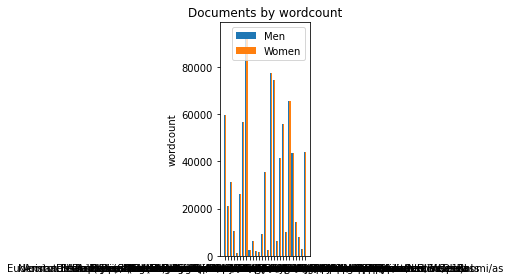

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = c_aristotelicum["title"].tolist()
lemmata_wordcounts_1 = c_aristotelicum["wordcount"]
lemmata_wordcounts_2 = c_aristotelicum["wordcount"]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lemmata_wordcounts_1, width, label='Men')
rects2 = ax.bar(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("wordcount")
ax.set_title("Documents by wordcount")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# export to sciencedata.dk
# currently Vojtěch Kaše's personal folder, but publicly shared
sddk.write_file("public_data/PIA/c_aristotelicum_cleaned.json", c_aristotelicum, conf)
sddk.write_file("public_data/PIA/c_hippocraticum_cleaned.json", c_hippocraticum, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_aristotelicum_cleaned.json"
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hippocraticum_cleaned.json"
